# PROJECT: Image classfication on CIFAR-10 dataset
CIFAR-10 contains 60k colour images fixed size of 32x32 pixels. There are 10 classes of images: airplane, automobile, bird, cat, deer, dog, frog, horse ship and truck.

Our goal is to classify set of pixels as an image of some of those classes.

We use methods such as:
- KNN
- PCA
- KPCA
- Gradient boosting
- SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy.stats as sstats
from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import (datasets, decomposition, ensemble, manifold, random_projection)
from sklearn.ensemble import GradientBoostingClassifier

from tqdm import tqdm

from KNN import KNN

## Data visualization
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_batch_1 = unpickle('cifar10/data_batch_1')
db1_labels = np.array(data_batch_1[b'labels'])
db1_data = np.array(data_batch_1[b'data'])

In [4]:
def make_viewables(db_data_photos):
    res = []
    for i in range(db_data_photos.shape[0]):
        res.append(db_data_photos[i].reshape(3,1024).T.reshape(32,32,3))
    return np.array(res)

db1_df = make_viewables(db1_data)

In [5]:
photo_indexes_to_show = np.random.randint(0, len(db1_data), size=100)

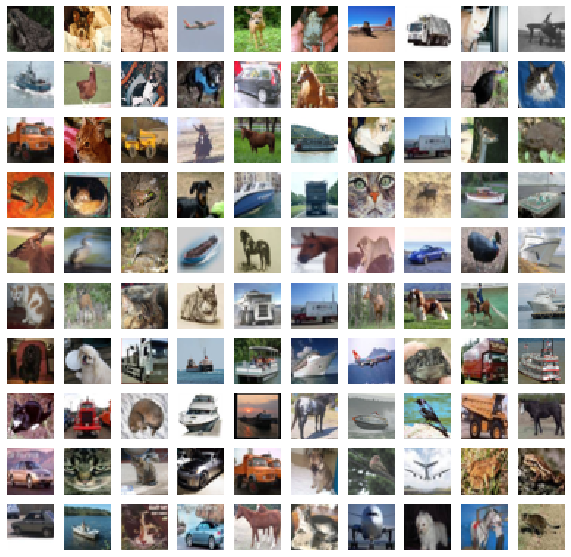

In [6]:
f, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(db1_df[photo_indexes_to_show[10*i+j]])
        axes[i][j].axis('off')
plt.axis('off');

## Does grayscaling affects image classification on this exact dataset?

Since it's speeding up computations.

In [7]:
def to_grayscale(x):
    new_x = x[:,:,0] * 0.3 + x[:, :, 1] * 0.59 + x[:, :, 2] * 0.11
    return new_x.astype(int)

In [8]:
def plot_method_acc(xs, ys, title, xlabel, is_barplot=False):
    plt.figure()
    plt.subplots(figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    if type(xs[0]) is str:
        plt.xticks(np.arange(len(xs)), labels=xs)
    else:
        plt.xticks(xs)
    plt.yticks(np.round(np.linspace(min(ys), max(ys), min(10, len(ys))), 1))
    plt.grid(axis='both', alpha=0.3)
    
    if is_barplot:
        plt.grid(axis='x', alpha=0)
        plt.bar(xs, height=ys)
    else:
        plt.plot(xs, ys)

In [9]:
train_x, test_x, train_y, test_y = train_test_split(db1_data, db1_labels, test_size=0.33)
train_x = train_x.reshape(-1, 32*32, 3)
test_x = test_x.reshape(-1, 32*32, 3)
gray_train_x = to_grayscale(train_x)
gray_test_x = to_grayscale(test_x)

In [10]:
ks = np.arange(1, 30, 2)
knn = KNN(train_x.reshape(-1, db1_data.shape[1]), train_y, test_x.reshape(-1, db1_data.shape[1]), ks)

original = []
grayscaled = []

for k in ks:
    original.append(np.count_nonzero(knn[k] == test_y) / len(test_y) * 100)

knn = KNN(gray_train_x, train_y, gray_test_x, ks)
for k in ks:
    grayscaled.append(np.count_nonzero(knn[k] == test_y) / len(test_y) * 100)

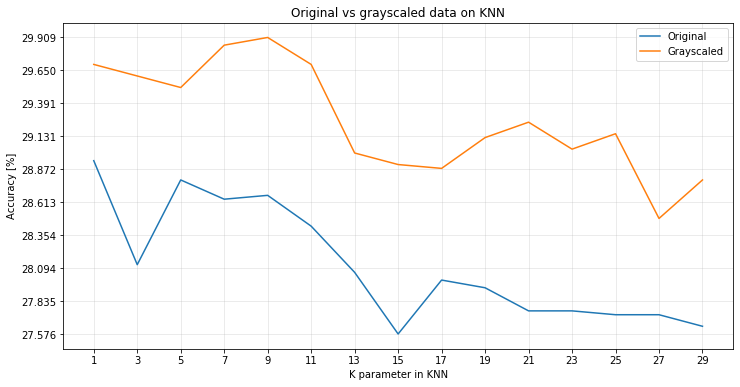

In [11]:
plt.subplots(figsize=(12,6))
plt.plot(ks, np.array(original), label='Original')
plt.plot(ks, np.array(grayscaled), label='Grayscaled')
plt.title('Original vs grayscaled data on KNN')
plt.xlabel('K parameter in KNN')
plt.ylabel('Accuracy [%]')
plt.xticks(ks)
plt.yticks(np.linspace(min(np.min(original), np.min(grayscaled)), max(np.max(original), np.max(grayscaled)), 10))
plt.grid(axis='both', alpha=0.3)
plt.legend();

In [12]:
accuracy_for_method = {}
train_x = gray_train_x
test_x = gray_test_x

## CIFAR-10 classification using k-nearest-neighbours algorithm

#### Comparison of parameters such as:
- number of neighbours to consider

#### Dimension reduction methods:
- sparse random projection
- PCA
- KPCA

<Figure size 432x288 with 0 Axes>

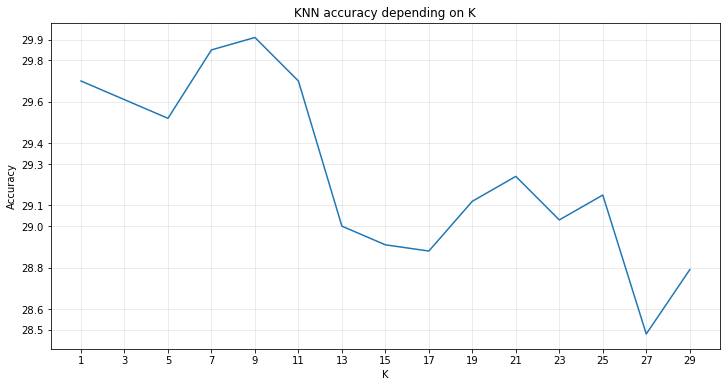

In [13]:
Ks = np.arange(1, 30, 2)
knn = KNN(train_x, train_y, test_x, Ks)
accs = []
for k in Ks:
    accs.append(np.round(np.count_nonzero(knn[k] == test_y) / len(test_y) * 100, 2))

accuracy_for_method['KNN'] = np.max(accs)
plot_method_acc(Ks, accs, 'KNN accuracy depending on K', 'K')

In [14]:
opt_k = Ks[np.argmax(accs)]
print("Best K param: ", opt_k)
print("Accuracy with this k:", np.max(accs))

Best K param:  9
Accuracy with this k: 29.91


### Sparse Random Projection
Sparse Random Projection reduces the dimensionality by projecting the original input space using a sparse random matrix.

In [15]:
def sparseRandomProj(train_x, test_x, train_y, test_y):
    OS = np.arange(10, 150, 5)
    accs = []
    for oss in tqdm(OS, position=0, leave=True):
        srp = random_projection.SparseRandomProjection(n_components=oss)
        x_proj = srp.fit_transform(train_x)
        x_test_proj = srp.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return OS, accs

OS, accs = sparseRandomProj(train_x, test_x, train_y, test_y)
accuracy_for_method['Sparse Random Proj'] = np.max(accs)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [01:00<00:00,  2.17s/it]


<Figure size 432x288 with 0 Axes>

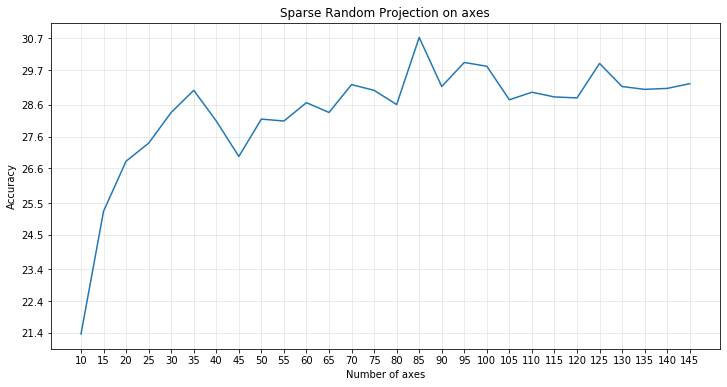

In [16]:
plot_method_acc(OS, accs, 'Sparse Random Projection on axes', 'Number of axes')

### Principial Component Analysis
Principial Component Analysis uses singular value decomposition to find eigenvectors, which helps us reduce dimensionality, keeping the relative distances approximately as simmilar as possible.

In [17]:
def pca(train_x, test_x, train_y, test_y):
    OS = np.arange(10, 100, 5)

    accs = []
    for oss in tqdm(OS, position=0, leave=True):
        pca = decomposition.PCA(n_components=oss)
        x_proj = pca.fit_transform(train_x)
        x_test_proj = pca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return OS, accs

OS, accs = pca(gray_train_x, gray_test_x, train_y, test_y)
accuracy_for_method['PCA'] = np.max(accs)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:42<00:00,  2.35s/it]


<Figure size 432x288 with 0 Axes>

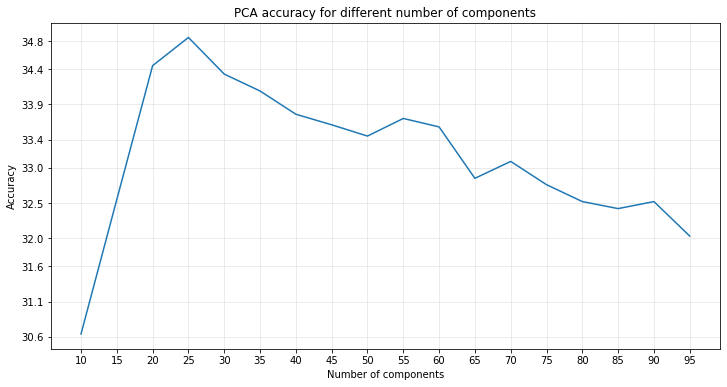

In [18]:
plot_method_acc(OS, accs, 'PCA accuracy for different number of components', 'Number of components')

## Kernelized PCA
Kernel PCA is an extension of PCA which achieves non-linear dimensionality reduction through the use of kernels.

Comparison of linear, polynomial, rbf, sigmoid and cosine kernels.

In [19]:
def kpca_kernels_comparison(train_x, test_x, train_y, test_y):
    kers = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

    accs = []
    for ker in tqdm(kers, position=1, leave=True):
        kpca = decomposition.KernelPCA(n_components=None, kernel=ker, gamma=0.01)
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return kers, accs
    
kers, accs = kpca_kernels_comparison(train_x, test_x, train_y, test_y)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:55<00:00, 95.05s/it]


<Figure size 432x288 with 0 Axes>

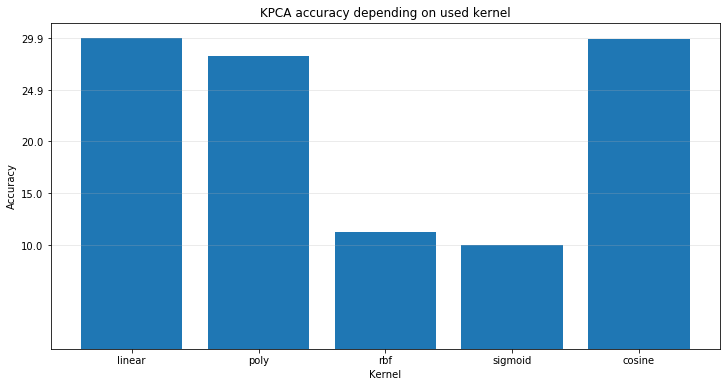

In [20]:
plot_method_acc(kers, accs, 'KPCA accuracy depending on used kernel', 'Kernel', is_barplot=True)

#### KPCA with linear kernel

In [21]:
def KPCA_linear(train_x, test_x, train_y, test_y):
    comps = np.arange(10, 50, 2)
    accs = []
    for i in tqdm(comps, position=0, leave=True):
        kpca = decomposition.KernelPCA(n_components=i, kernel='linear')
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    
    return comps, accs
        
comps, accs = KPCA_linear(train_x, test_x, train_y, test_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:10<00:00, 24.52s/it]


In [22]:
accuracy_for_method['KPCA_lin'] = np.max(accs)

<Figure size 432x288 with 0 Axes>

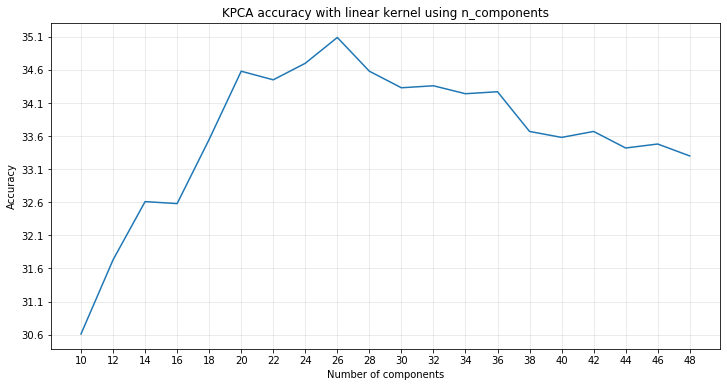

In [23]:
plot_method_acc(comps, accs, 'KPCA accuracy with linear kernel using n_components', 'Number of components')

#### KPCA with polynomial kernel

In [24]:
def KPCA_poly_deg(train_x, test_x, train_y, test_y):
    degrees = np.arange(1, 8, 1)
    accs = []
    for g in tqdm(degrees, position=0, leave=True):
        kpca = decomposition.KernelPCA(n_components=12, kernel='poly', degree=g)
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return degrees, accs

degrees, accs = KPCA_poly_deg(train_x, test_x, train_y, test_y)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:02<00:00, 26.03s/it]


In [25]:
accuracy_for_method['KPCA_poly'] = np.max(accs)

<Figure size 432x288 with 0 Axes>

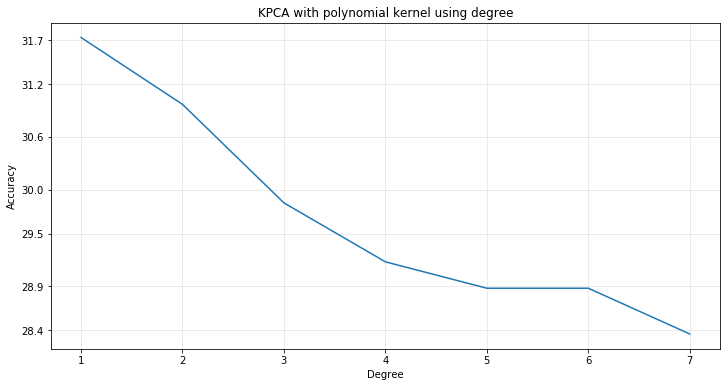

In [26]:
plot_method_acc(degrees, accs, 'KPCA with polynomial kernel using degree', 'Degree')

#### KPCA with cosine kernel

In [27]:
def KPCA_cos_comps(train_x, test_x, train_y, test_y):
    comps = np.append(np.arange(10,30,2), [40,50,60,90,150,300])
    accs = []
    for i in tqdm(comps, position=0, leave=True):
        kpca = decomposition.KernelPCA(n_components=i, kernel='cosine')
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return comps, accs

comps, accs = KPCA_cos_comps(train_x, test_x, train_y, test_y)
accuracy_for_method['KPCA_cos'] = np.max(accs)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [06:36<00:00, 24.77s/it]


<Figure size 432x288 with 0 Axes>

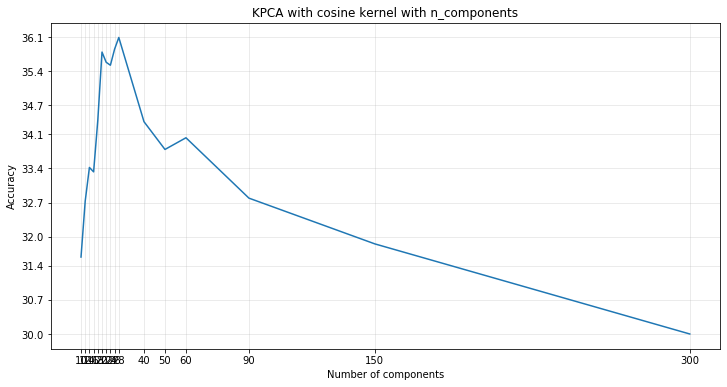

In [28]:
plot_method_acc(comps, accs, 'KPCA with cosine kernel with n_components', 'Number of components')

## Gradient Boosting Classifier
Forest of weak classification trees of given maximal depth. After each classification, missclassified samples weights are getting bigger, forcing next classifing tree to look at them differently. Final results are given by majority vote over all trees.

In [29]:
def gradient_boost(train_x, test_x, train_y, test_y):
    max_depths = np.arange(1, 6)
    accs = []
    
    for md in tqdm(max_depths, position=1, leave=True):
        clf = GradientBoostingClassifier(max_depth=md)    
        clf.fit(train_x, train_y)
        preds = clf.predict(test_x)
        acc = np.round(np.count_nonzero(preds == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return max_depths, accs        

In [30]:
max_depths, accs = gradient_boost(train_x, test_x, train_y, test_y)
accuracy_for_method['Gradient Boosting'] = np.max(accs)


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:35:24<00:00, 1144.94s/it]


<Figure size 432x288 with 0 Axes>

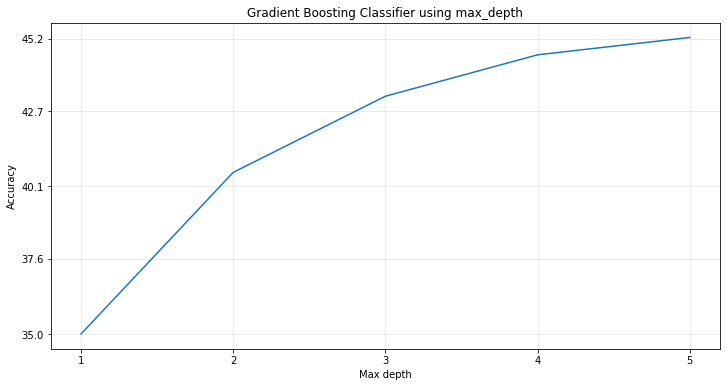

In [31]:
plot_method_acc(max_depths, accs, 'Gradient Boosting Classifier using max_depth', 'Max depth')

## Support Vector Classifier
SVM algorithm but for multi-class classification.

In [32]:
def svm(train_x, test_x, train_y, test_y):
    k = 'poly'
    degrees = np.arange(1, 6)
    accs = []

    for d in tqdm(degrees, position=0, leave=True):
        svc = SVC(kernel=k, gamma='scale', degree=d)
        svc.fit(train_x, train_y)
        preds = svc.predict(test_x)
        acc = np.round(np.count_nonzero(preds == test_y) / len(test_y) * 100, 2)
        accs.append(acc)

    return degrees, accs

In [33]:
degrees, accs = svm(train_x, test_x, train_y, test_y)
accuracy_for_method['Support Vector'] = np.max(accs)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:56<00:00, 83.37s/it]


<Figure size 432x288 with 0 Axes>

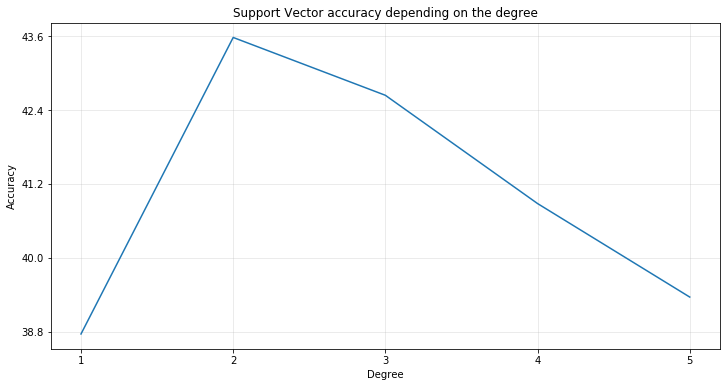

In [34]:
plot_method_acc(degrees, accs, 'Support Vector accuracy depending on the degree', 'Degree')

## Methods summary
Gradient boosting and SVC are scoring the best results among all algorithms used on batches of CIFAR-10. We choose SVC, because the time needed to build and run high-performance forest used in gradient boosting is enormous.

<Figure size 432x288 with 0 Axes>

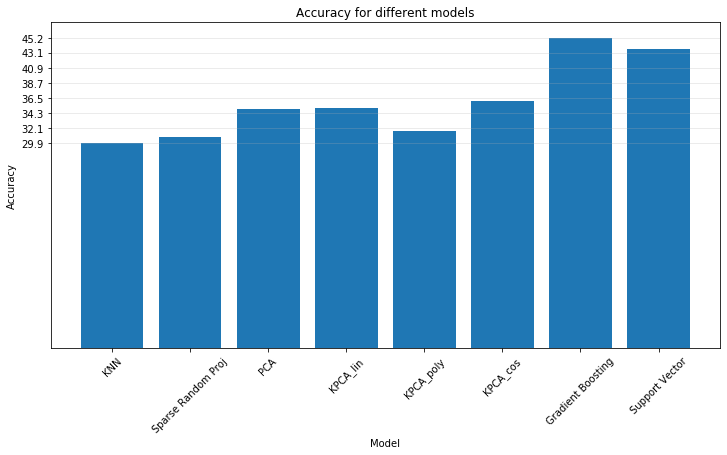

In [39]:
plot_method_acc(list(accuracy_for_method.keys()), list(accuracy_for_method.values()), 
                'Accuracy for different models', 'Model', is_barplot=True)
plt.xticks(rotation=45)
plt.show()

## Full dataset classification using SVC

Ships and automobiles are the best classified classes with accuracy over 60%, while cats and dogs are the most often missclassified.

In [2]:
preds = open('preds.txt').read()[1:-1].split(', ')
true_labels = open('true_labels.txt').read()[1:-1].split(', ')
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [6]:
conf_matrix = confusion_matrix(true_labels, preds)
acc = np.round(np.count_nonzero(np.array(true_labels) == np.array(preds)) / len(preds), 2)

print(f'Accuracy: {acc}')
print(f'Confusion matrix:\n{conf_matrix}')
print('\nClasses:\n' + ', '.join(labels))

Accuracy: 0.5
Confusion matrix:
[[ 934   70   92   52   76   43   46   51  204   88]
 [  68 1022   41   54   36   21   55   38  109  210]
 [ 166   33  676  131  256   81  209   76   41   29]
 [  52   47  186  554  120  270  230   63   53   58]
 [  93   27  215   98  724   86  242  129   41   25]
 [  42   43  176  339  112  595  148   89   28   34]
 [  25   26  135  163  154   92  938   30   15   32]
 [  83   37  143  105  183   85   62  849   34   65]
 [ 193   95   44   43   48   36   17   18 1079   92]
 [  92  262   47   62   34   53   52   58  100  892]]

Classes:
Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck


In [7]:
for s, l in np.c_[np.diag(conf_matrix) / np.sum(conf_matrix, axis=1), labels]:
    print(f'{l}: {np.round(float(s), 2)}')

Airplane: 0.56
Automobile: 0.62
Bird: 0.4
Cat: 0.34
Deer: 0.43
Dog: 0.37
Frog: 0.58
Horse: 0.52
Ship: 0.65
Truck: 0.54


<BarContainer object of 10 artists>

<Figure size 432x288 with 0 Axes>

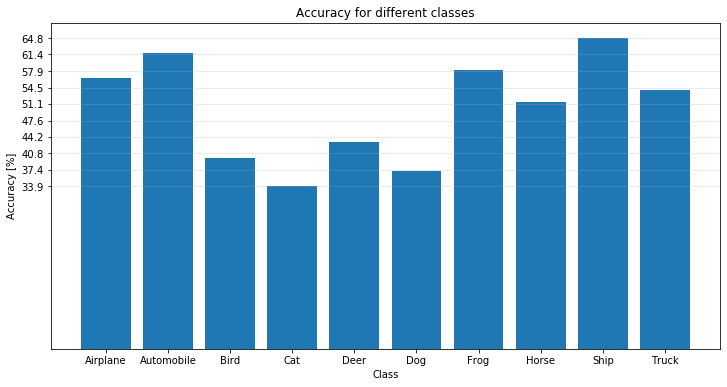

In [10]:
xs = list(labels)
ys = list(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)* 100)
plt.figure()
plt.subplots(figsize=(12, 6))
plt.title('Accuracy for different classes')
plt.xlabel('Class')
plt.ylabel('Accuracy [%]')
plt.xticks(np.arange(len(xs)), labels=xs)
plt.yticks(np.round(np.linspace(min(ys), max(ys), min(10, len(ys))), 1))
plt.grid(axis='both', alpha=0.3)
plt.grid(axis='x', alpha=0)
plt.bar(xs, height=ys)